In [ ]:
!pull tensorflow/tensorflow:latest  # Download latest stable image
!run -it -p 8888:8888 tensorflow/tensorflow:latest-jupyter  # Start Jupyter server

/bin/bash: line 1: pull: command not found
/bin/bash: line 1: run: command not found


In [ ]:
import tensorflow as tf
from tensorflow import keras


In [ ]:
!pip install keras-rl

In [ ]:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.15.0


#Loading Data

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from jax import numpy as jnp
import numpy as np

(X_train, Y_train), (X_test, Y_test) = keras.datasets.fashion_mnist.load_data()

X_train, X_test = X_train.reshape(-1,28,28,1), X_test.reshape(-1,28,28,1)

X_train, X_test = X_train/255.0, X_test/255.0

classes =  np.unique(Y_train)
class_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
mapping = dict(zip(classes, class_labels))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

4422102/4422102 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

#Defining CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"),

    layers.Flatten(),
    layers.Dense(len(classes), activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 10)                125450    
                                                                 
Total params: 130394 (509.35 KB)
Trainable params: 130394 (509.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#Compiling And Training the Model

In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", ["accuracy"])


In [ ]:
model.fit(X_train, Y_train, batch_size=256, epochs=10, validation_data=(X_test, Y_test))


Epoch 1/10
235/235 [==============================] - 86s 362ms/step - loss: 0.5240 - accuracy: 0.8214 - val_loss: 0.4048 - val_accuracy: 0.8588
Epoch 2/10
235/235 [==============================] - 70s 296ms/step - loss: 0.3463 - accuracy: 0.8779 - val_loss: 0.3433 - val_accuracy: 0.8814
Epoch 3/10
235/235 [==============================] - 70s 299ms/step - loss: 0.3029 - accuracy: 0.8917 - val_loss: 0.3362 - val_accuracy: 0.8749
Epoch 4/10
235/235 [==============================] - 70s 298ms/step - loss: 0.2698 - accuracy: 0.9032 - val_loss: 0.2984 - val_accuracy: 0.8924
Epoch 5/10
235/235 [==============================] - 70s 300ms/step - loss: 0.2446 - accuracy: 0.9125 - val_loss: 0.2880 - val_accuracy: 0.8947
Epoch 6/10
235/235 [==============================] - 70s 299ms/step - loss: 0.2280 - accuracy: 0.9183 - val_loss: 0.2884 - val_accuracy: 0.8968
Epoch 7/10
235/235 [==============================] - 72s 305ms/step - loss: 0.2131 - accuracy: 0.9235 - val_loss: 0.2679 - val_ac

#Evaluating Model Performance

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Y_test_preds = model.predict(X_test)
Y_test_preds = np.argmax(Y_test_preds, axis=1)

print("Test Accuracy : {}".format(accuracy_score(Y_test, Y_test_preds)))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_test, Y_test_preds))
print("\nClassification Report :")
print(classification_report(Y_test, Y_test_preds, target_names=class_labels))

313/313 [==============================] - 3s 10ms/step
Test Accuracy : 0.9094

Confusion Matrix : 
[[868   0  28  26   4   2  63   0   9   0]
 [  2 980   0  12   3   0   2   0   1   0]
 [ 11   1 896   9  50   0  33   0   0   0]
 [ 15   4  12 937  18   1  10   0   3   0]
 [  1   1  70  27 867   0  34   0   0   0]
 [  0   0   0   0   0 991   0   8   0   1]
 [134   0  91  37  79   0 651   0   8   0]
 [  0   0   0   0   0  11   0 979   0  10]
 [  4   1   3   1   5   3   2   3 978   0]
 [  0   0   0   0   0  12   1  40   0 947]]

Classification Report :
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.87      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.81      0.90      0.85      1000
       Dress       0.89      0.94      0.91      1000
        Coat       0.85      0.87      0.86      1000
      Sandal       0.97      0.99      0.98      1000
       Shirt       0.82      0.65      0.72      1000
     Sneake

#SHAP Partition Explainer

In [ ]:
!pip install shap
import shap

In [ ]:
shap.initjs()

In [ ]:
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_labels)

explainer

#Visualizing SHAP Values For Correct Predictions

In [ ]:
shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

(4, 28, 28, 1, 5)

In [ ]:
print("Actual Labels    : {}".format([mapping[i] for i in Y_test[:4]]))
probs = model.predict(X_test[:4])
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

Actual Labels    : ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
1/1 [==============================] - 0s 20ms/step
Predicted Labels : ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
Probabilities : [0.99738353 0.99864453 0.9999974  0.9999981 ]


#Image plot

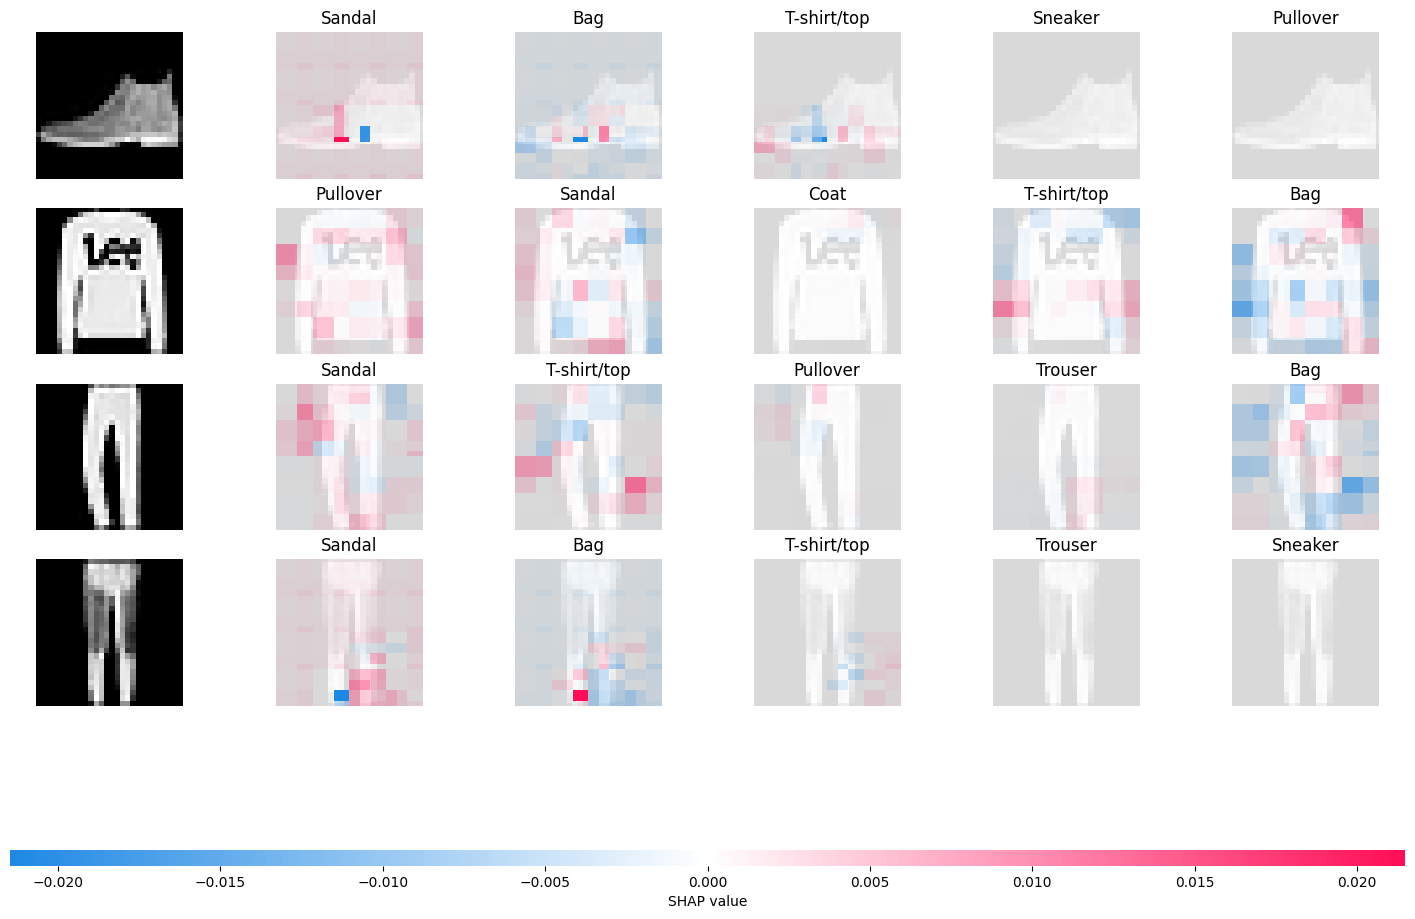

In [ ]:
shap.image_plot(shap_values)

#Other image plot

A different masker named inpaint_ns

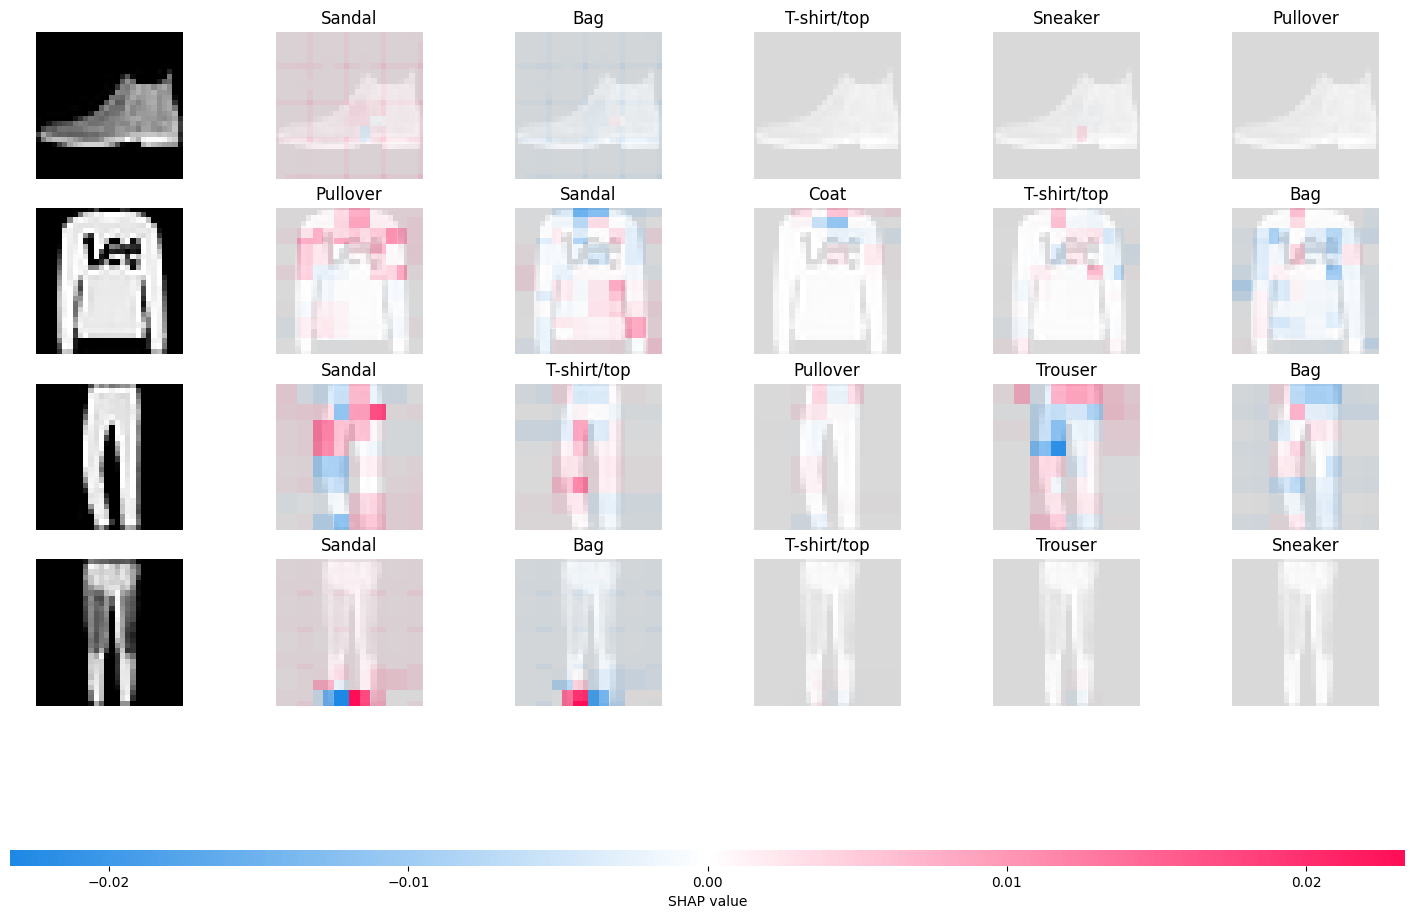

In [ ]:
masker = shap.maskers.Image("inpaint_ns", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_labels)

shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

 # Another image plot using masker ( blurring-based masker)

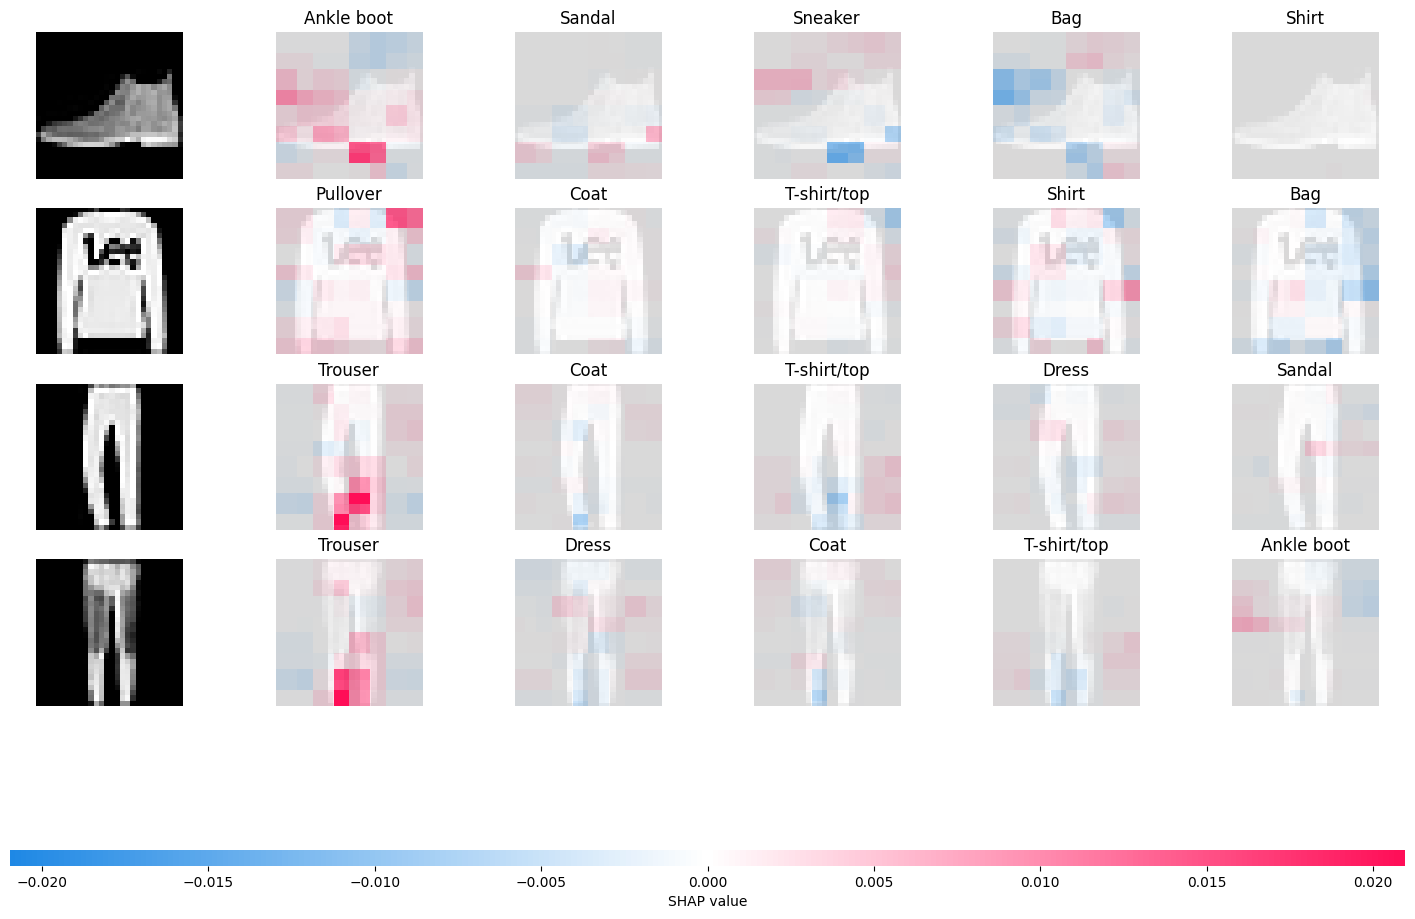

In [ ]:
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_labels)

shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

#Visualizibg SHAP Values For Incorrect Predictions

In [ ]:
wrong_preds_idx = np.argwhere(Y_test!=Y_test_preds)

X_batch = X_test[wrong_preds_idx.flatten()[:4]]
Y_batch = Y_test[wrong_preds_idx.flatten()[:4]]

print("Actual Labels    : {}".format([mapping[i] for i in Y_batch]))
probs = model.predict(X_batch)
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

Actual Labels    : ['Sneaker', 'Ankle boot', 'Coat', 'Dress']
1/1 [==============================] - 0s 32ms/step
Predicted Labels : ['Sandal', 'Sandal', 'Pullover', 'T-shirt/top']
Probabilities : [0.8287613  0.9999343  0.5420294  0.35718295]


An image plot using by generating shap values for wrong predictions

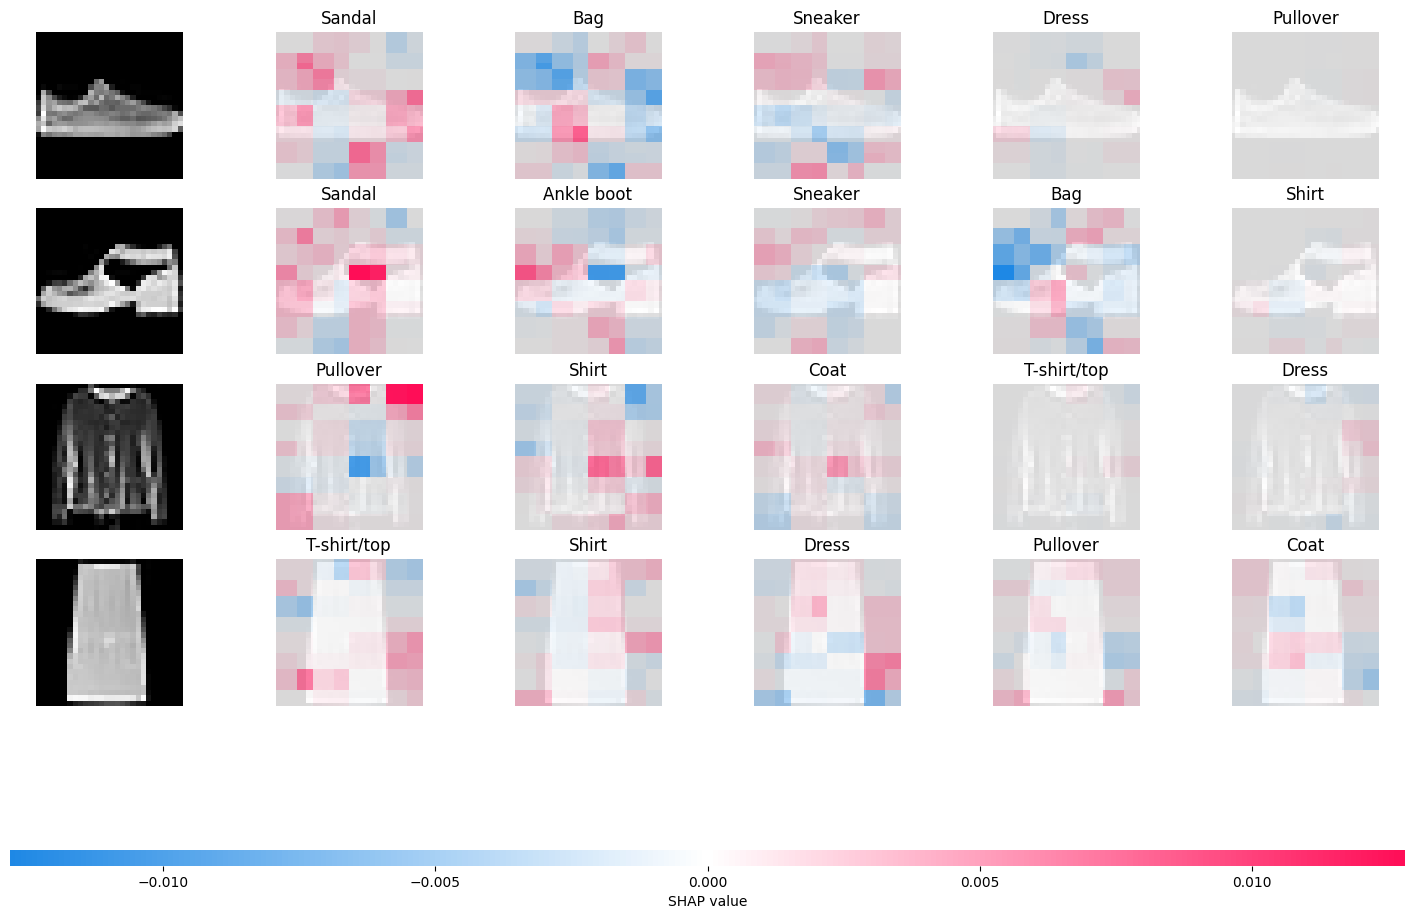

In [ ]:
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_labels)

shap_values = explainer(X_batch, outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

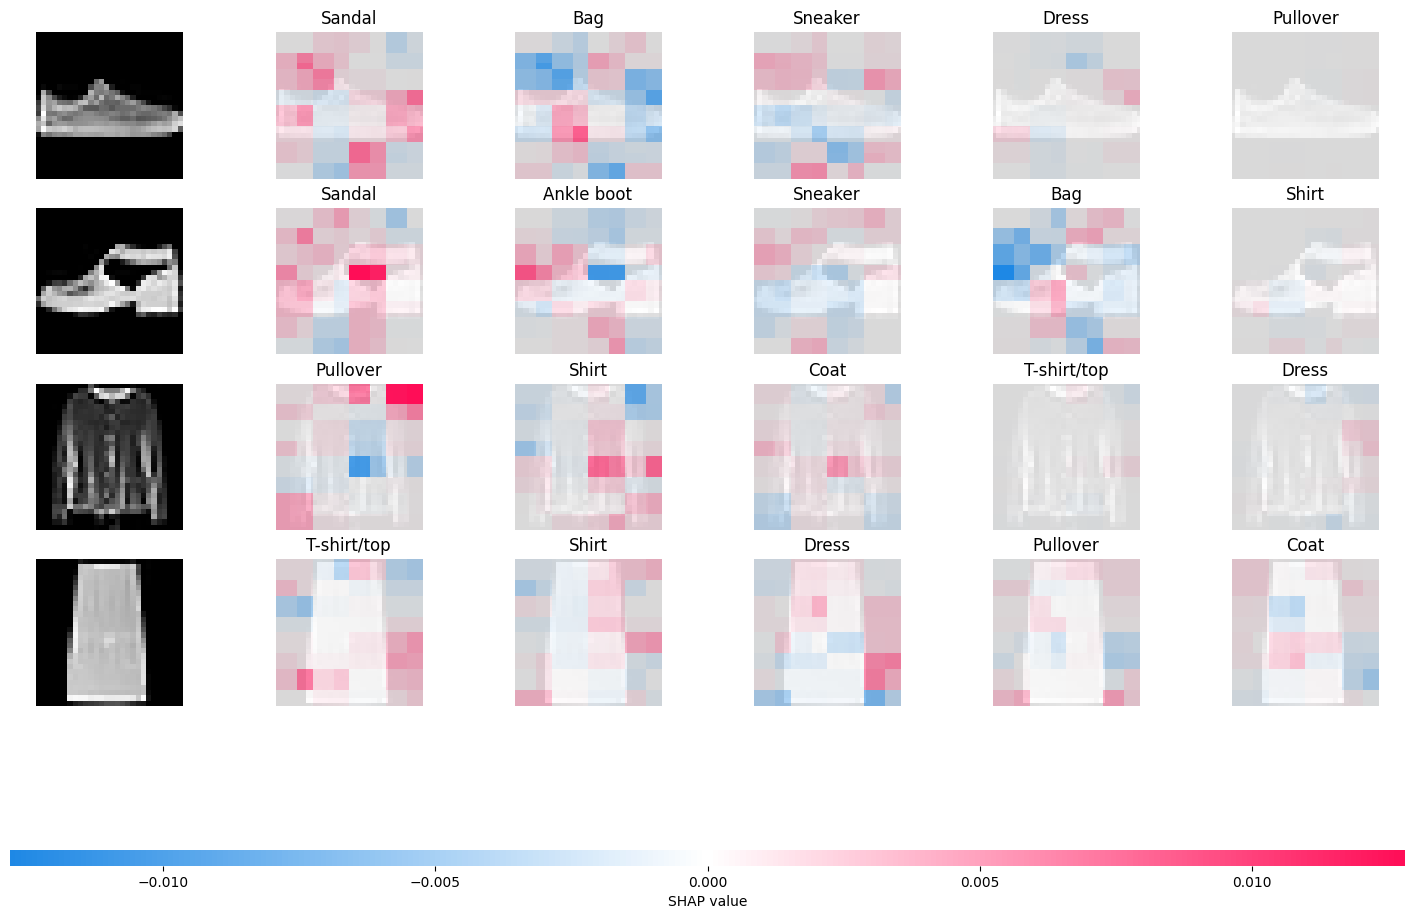

In [ ]:
shap.plots.image(shap_values)

#SHAP Permutation Explainer

In [ ]:
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.PermutationExplainer(model, masker, output_names=class_labels)

explainer

<shap.explainers._permutation.PermutationExplainer.__init__.<locals>.PermutationExplainer at 0x7b293bfe4dc0>

#Visualizing SHAP Values For Correct Predictions

In [ ]:
shap_values = explainer(X_test[:4], max_evals=1600, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

(4, 28, 28, 1, 10)

In [ ]:
print("Actual Labels    : {}".format([mapping[i] for i in Y_test[:4]]))
probs = model.predict(X_test[:4])
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

Actual Labels    : ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
1/1 [==============================] - 0s 35ms/step
Predicted Labels : ['Ankle boot', 'Pullover', 'Trouser', 'Trouser']
Probabilities : [0.99738353 0.99864453 0.9999974  0.9999981 ]


In [ ]:
Y_preds = model.predict(X_test[:4])

Y_preds = Y_preds.argsort()[:, ::-1]
Y_labels = [[class_labels[val] for val in row] for row in Y_preds]
Y_labels=np.array(Y_labels)

Y_labels

1/1 [==============================] - 0s 25ms/step


array([['Ankle boot', 'Sandal', 'Sneaker', 'Bag', 'Shirt', 'Pullover',
        'Coat', 'T-shirt/top', 'Dress', 'Trouser'],
       ['Pullover', 'Coat', 'T-shirt/top', 'Shirt', 'Bag', 'Dress',
        'Trouser', 'Sandal', 'Ankle boot', 'Sneaker'],
       ['Trouser', 'Coat', 'T-shirt/top', 'Dress', 'Sandal', 'Bag',
        'Shirt', 'Pullover', 'Ankle boot', 'Sneaker'],
       ['Trouser', 'Dress', 'Coat', 'T-shirt/top', 'Ankle boot', 'Shirt',
        'Sandal', 'Bag', 'Pullover', 'Sneaker']], dtype='<U11')

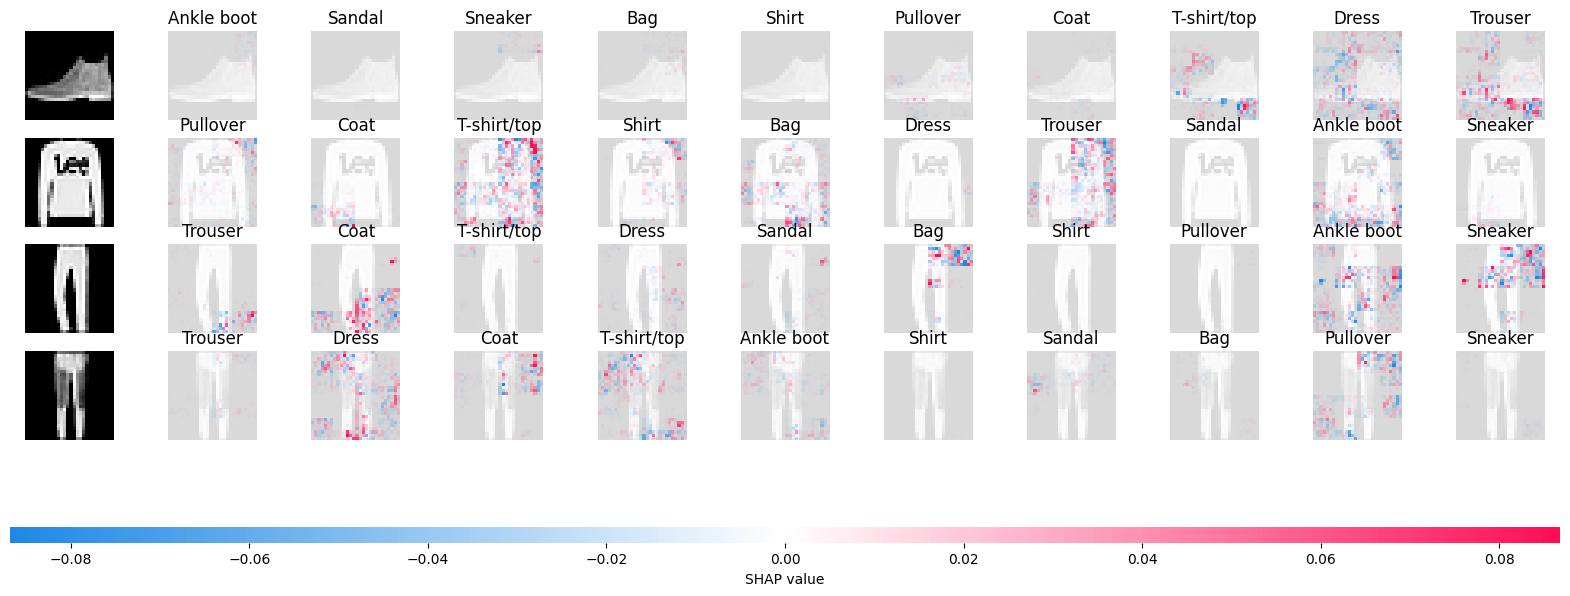

In [ ]:
shap.image_plot(shap_values, labels=Y_labels)

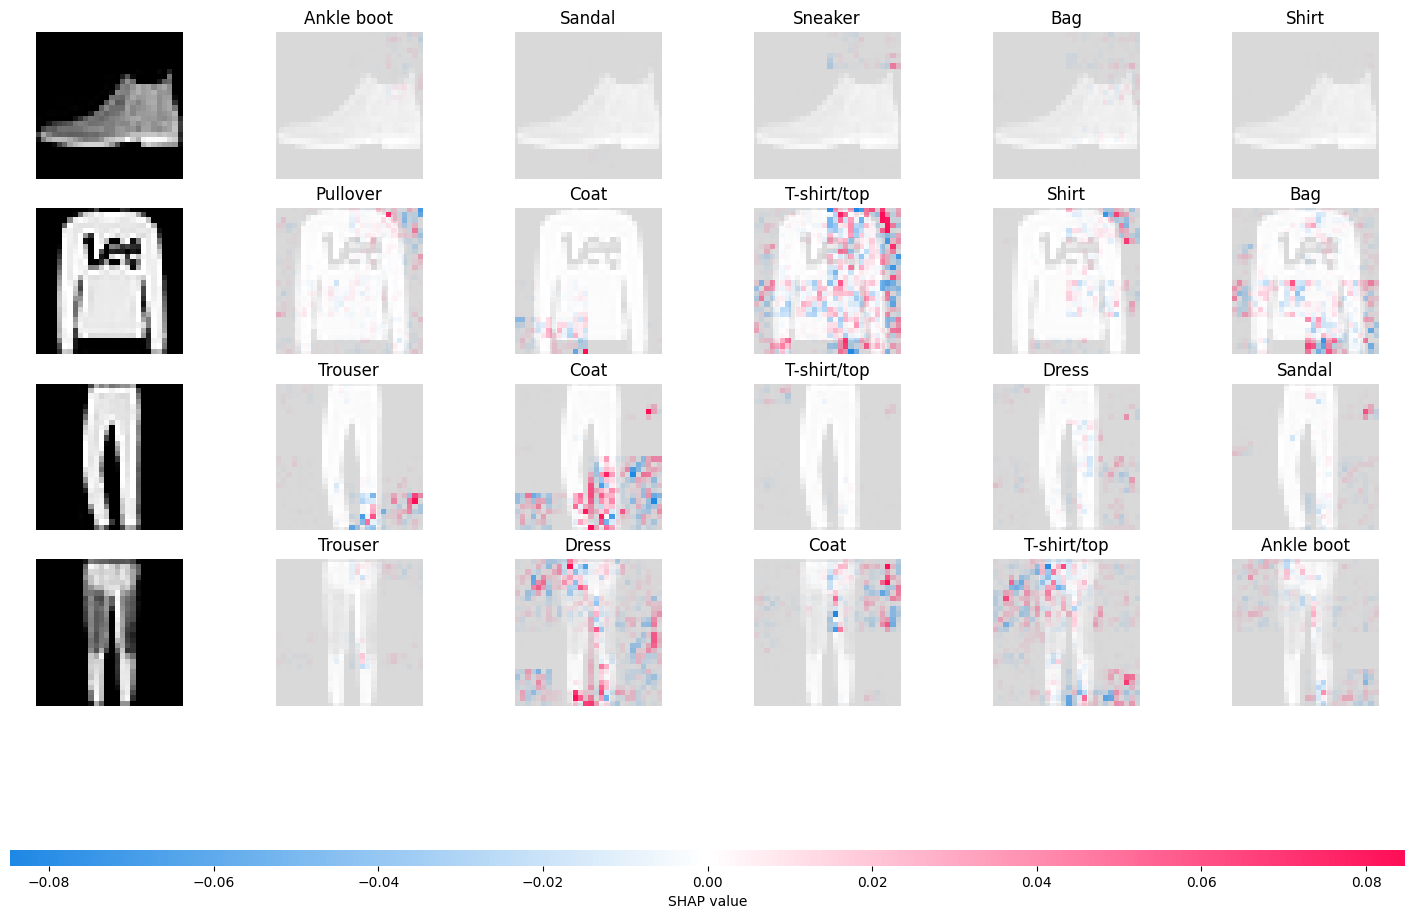

In [ ]:
shap.image_plot(shap_values[:,:,:,:,:5], labels=Y_labels[:,:5])

#Visualizing SHAP Values For Incorrect Predictions

In [ ]:
wrong_preds_idx = np.argwhere(Y_test!=Y_test_preds)

X_batch = X_test[wrong_preds_idx.flatten()[:4]]
Y_batch = Y_test[wrong_preds_idx.flatten()[:4]]

print("Actual Labels    : {}".format([mapping[i] for i in Y_batch]))
probs = model.predict(X_batch)
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

Actual Labels    : ['Sneaker', 'Ankle boot', 'Coat', 'Dress']
1/1 [==============================] - 0s 20ms/step
Predicted Labels : ['Sandal', 'Sandal', 'Pullover', 'T-shirt/top']
Probabilities : [0.8287613  0.9999343  0.5420294  0.35718295]


In [ ]:
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.PermutationExplainer(model, masker, output_names=class_labels)

shap_values = explainer(X_batch, max_evals=1600, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

(4, 28, 28, 1, 10)

In [ ]:
Y_preds = model.predict(X_batch)

Y_preds = Y_preds.argsort()[:, ::-1]
Y_labels = [[class_labels[val] for val in row] for row in Y_preds]
Y_labels=np.array(Y_labels)

Y_labels

1/1 [==============================] - 0s 52ms/step


array([['Sandal', 'Bag', 'Sneaker', 'Dress', 'Pullover', 'Ankle boot',
        'Coat', 'Shirt', 'T-shirt/top', 'Trouser'],
       ['Sandal', 'Ankle boot', 'Sneaker', 'Bag', 'Shirt', 'T-shirt/top',
        'Pullover', 'Dress', 'Coat', 'Trouser'],
       ['Pullover', 'Shirt', 'Coat', 'T-shirt/top', 'Dress', 'Trouser',
        'Bag', 'Sandal', 'Ankle boot', 'Sneaker'],
       ['T-shirt/top', 'Shirt', 'Dress', 'Pullover', 'Coat', 'Bag',
        'Trouser', 'Sneaker', 'Sandal', 'Ankle boot']], dtype='<U11')

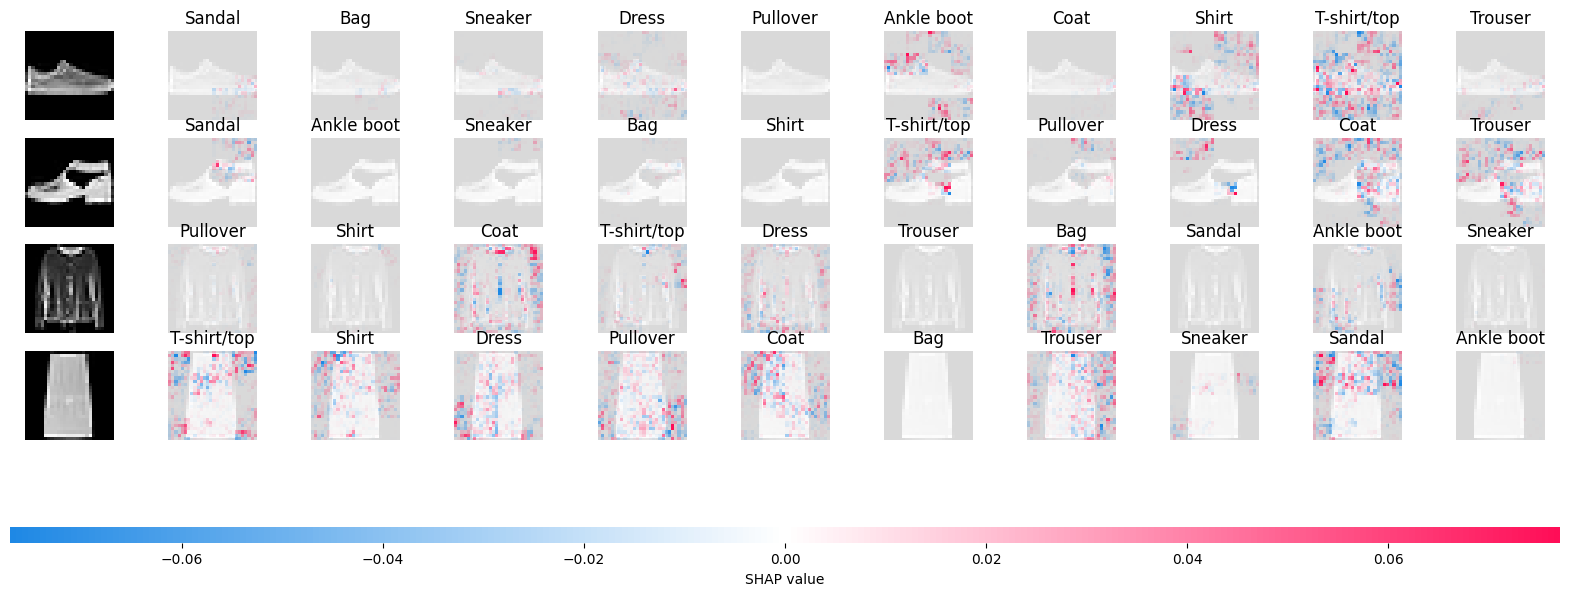

In [ ]:
shap.image_plot(shap_values, labels=Y_labels)

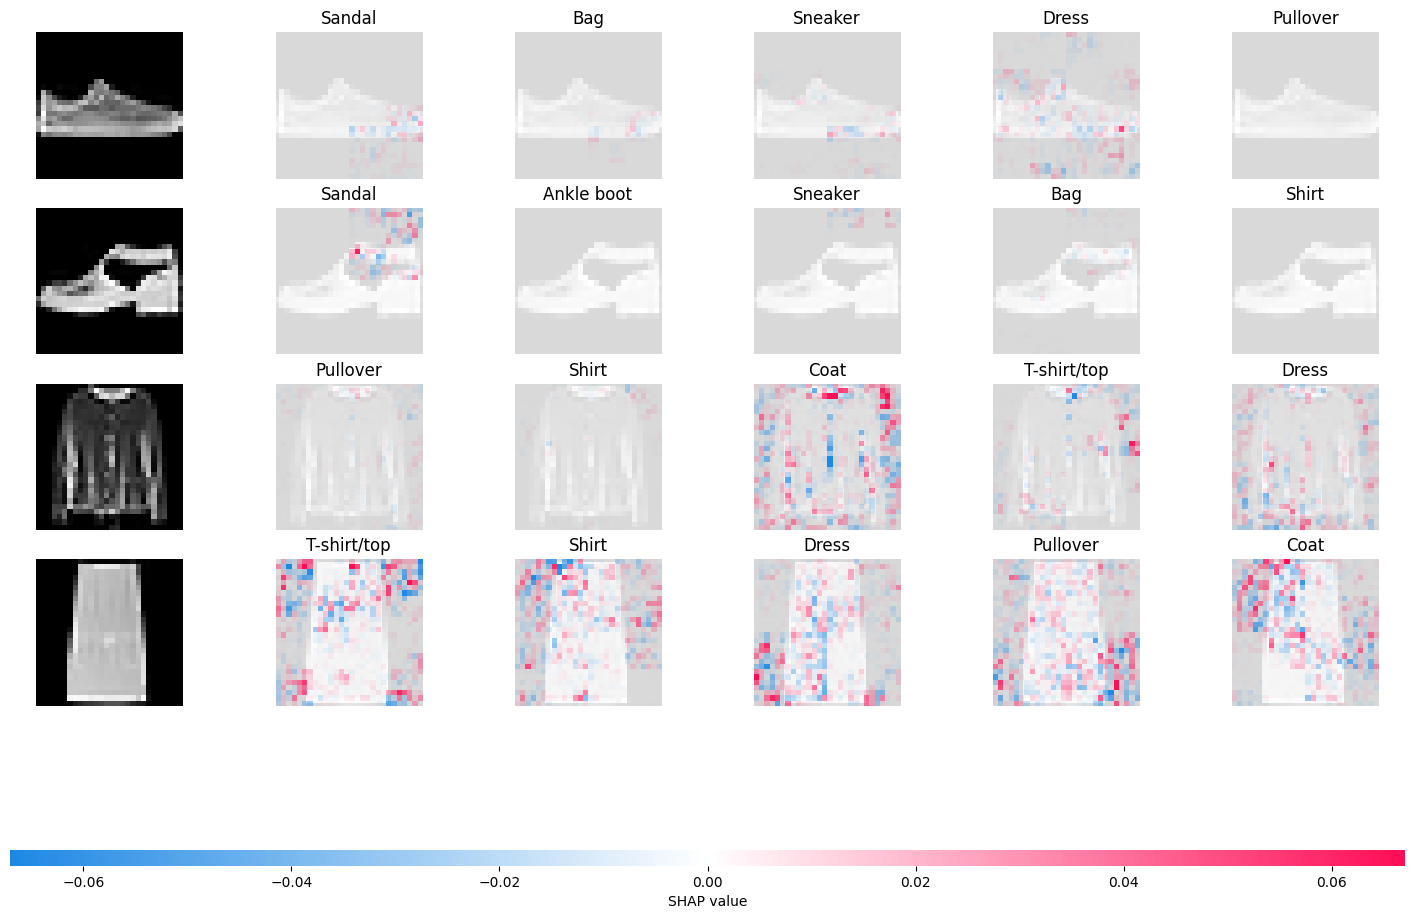

In [ ]:
shap.image_plot(shap_values[:,:,:,:,:5], labels=Y_labels[:,:5])